### Importing Modules

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
import datetime

import gym
from gym.wrappers.record_video import RecordVideo

import glob
import io
import base64

import matplotlib.pyplot as plt

### Defining the two game environments

In [2]:
#Defining Environments

#Environment 2

env2 = gym.make("CartPole-v1")
env2.seed(0)

env2_state_shape = env2.observation_space.shape[0]
env2_no_of_actions = env2.action_space.n

env2_state = env2.reset()


# Note For both Environments
# For choosing actions :
# action = env.action_space.sample()

# For step :
# next_state, reward, done, info = env.step(action)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Defining the two Neural networks required

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 40

class QNetwork1(nn.Module):
  def __init__(self, state_size, action_size, seed, fc1_units = 64, fc2_units = 32):
    super(QNetwork1, self).__init__()
    self.seed = torch.manual_seed(seed)                                               # Making the initialization of weights the same all the time
    self.fc1 = nn.Linear(state_size, fc1_units)
    self.fc2 = nn.Linear(fc1_units, fc2_units)
    self.V = nn.Linear(fc2_units, 1)
    self.A = nn.Linear(fc2_units, action_size)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    V = self.V(x)
    A = self.A(x)
    return V + A - A.mean()

class QNetwork2(nn.Module):
  def __init__(self, state_size, action_size, seed, fc1_units = 64, fc2_units = 32):
    super(QNetwork2, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, fc1_units)
    self.fc2 = nn.Linear(fc1_units, fc2_units)
    self.V = nn.Linear(fc2_units, 1)
    self.A = nn.Linear(fc2_units, action_size)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    V = self.V(x)
    A = self.A(x)
    return V + A - A.max()

### Class for Replay buffer

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.memory = deque(maxlen = buffer_size)                                                                       # Memory that stores experiences
    self.batch_size = batch_size                                                                                    # Stores batch size for sampling
    self.experience = namedtuple('Experience', field_names = ["state", "action", "reward", "next_state", "done"])   # Named Tuple that is used to store experience
    self.seed = random.seed(seed)

  def add(self, state, action, reward, next_state, done):                                                         # Function for adding experiences in memory
    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)

  def sample(self):                                                                                               # Sampling experiences randomly
    experiences = random.sample(self.memory, k = self.batch_size)

    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)

### Defining tutorial agent, where it learns and acts according to the policy

In [6]:
class TutorialAgent():
  def __init__(self, state_size, action_size, seed, fc1_units, fc2_units, tau = 0.1, QNetwork = QNetwork1):
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.qnetwork_local = QNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)                  # Local network
    self.qnetwork_target = QNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)                 # Target network
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = LR)

    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)         # To store experiences and sample

    self.t_step = 0                                                                # For maintaining a count of when to update Target Q network
    self.tau = tau                                                                 # Parameter for updating Target Q network using Polyak updation

  def step(self, state, action, reward, next_state, done):
    self.memory.add(state, action, reward, next_state, done)

    if len(self.memory) >= BATCH_SIZE:
      experiences = self.memory.sample()
      self.learn(experiences)

    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
      self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

  def act(self, state, eps = 0.0):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)                           # Conveting the numpy array to a torch tensor

    self.qnetwork_local.eval()                                                     # The model is set to evaluating
    with torch.no_grad():                                                          # Evaluation is done without taking gradients
      action_values = self.qnetwork_local(state)                                   # The Q values are obtained
    self.qnetwork_local.train()                                                    # The model is set to training

    if random.random() > eps:                                                      # Implementing of Epsilon greedy policy
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    Q_targets = rewards + GAMMA * Q_targets_next * (1 - dones)
    Q_current = self.qnetwork_local(states).gather(1, actions)

    loss = F.mse_loss(Q_targets, Q_current)

    self.optimizer.zero_grad()
    loss.backward()

    for param in self.qnetwork_local.parameters():                                 # Gradient clipping
      param.grad.data.clamp_(-1, 1)                                                # For preventing exploding gradient situation

    self.optimizer.step()

### A class for running Dueling DQN

In [10]:
class dueling_dqn:
  def __init__(self, fc1_units, fc2_units, env = env2, QNetwork = QNetwork1, tau = 0.1, seed = 0):
    self.env = env
    self.state_shape = env.observation_space.shape[0]
    self.action_space = env.action_space.n
    self.agent = TutorialAgent(self.state_shape, self.action_space, seed, fc1_units, fc2_units, tau = tau, QNetwork = QNetwork)

  def run(self, n_episodes = 500, max_t = 500, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.995):
    returns = deque()
    scores = deque(maxlen = 100)
    eps = eps_start
    for i in range(1, n_episodes + 1):
      state = self.env.reset()
      ep_reward = 0
      rewards = deque()
      while True:
        action = self.agent.act(state, eps)
        next_state, reward, done, _ = self.env.step(action)
        self.agent.step(state, action, reward, next_state, done)
        state = next_state
        ep_reward += reward
        rewards.append(reward)

        if done:
          break
      eps = max(eps_end, eps_decay * eps)
      scores.append(ep_reward)
      R = 0
      for r in list(rewards):
        R = r + R
      print(f"Episode number {i}, and it's corresponding return is {R}, average rewards : {np.mean(scores)}")
      returns.append(R)
    return list(returns)

### Tuning of Parameters
- Tuned for Hidden Layer nodes (fc1_nodes, fc2_nodes) = (128, 64), (64, 32), (32, 16), (16, 8)

In [9]:
from tqdm import tqdm
def tuning(env = env2, QNetwork = QNetwork1):
    upper_limit = 500
    hyper_parameters = [(128, 64), (64, 32), (32, 16), (16, 8)]
    dictionary = {}
    for par in tqdm(hyper_parameters):
        tuning_Duel_DQN = dueling_dqn(fc1_units = par[0], fc2_units = par[1], QNetwork = QNetwork, seed = 0)
        returns = tuning_Duel_DQN.run()
        regret = [upper_limit - r for r in returns]
        dictionary[par] = np.sum(np.array(regret))
    return dictionary, min(dictionary.keys(), key = lambda x : dictionary[x]) # Returns the dictionary and the pair with minimum regret

In [11]:
dict_2_1, opt_par_2_1 = tuning()

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode number 1, and it's corresponding return is 14.0, average rewards : 14.0
Episode number 2, and it's corresponding return is 18.0, average rewards : 16.0
Episode number 3, and it's corresponding return is 11.0, average rewards : 14.333333333333334
Episode number 4, and it's corresponding return is 21.0, average rewards : 16.0
Episode number 5, and it's corresponding return is 18.0, average rewards : 16.4
Episode number 6, and it's corresponding return is 32.0, average rewards : 19.0
Episode number 7, and it's corresponding return is 14.0, average rewards : 18.285714285714285
Episode number 8, and it's corresponding return is 22.0, average rewards : 18.75
Episode number 9, and it's corresponding return is 18.0, average rewards : 18.666666666666668
Episode number 10, and it's corresponding return is 26.0, average rewards : 19.4
Episode number 11, and it's corresponding return is 26.0, average rewards : 20.0
Episode number 12, and it's corresponding return is 16.0, average rewards :

 25%|██▌       | 1/4 [07:11<21:34, 431.46s/it]

Episode number 500, and it's corresponding return is 227.0, average rewards : 84.19
Episode number 1, and it's corresponding return is 16.0, average rewards : 16.0
Episode number 2, and it's corresponding return is 26.0, average rewards : 21.0
Episode number 3, and it's corresponding return is 27.0, average rewards : 23.0
Episode number 4, and it's corresponding return is 49.0, average rewards : 29.5
Episode number 5, and it's corresponding return is 15.0, average rewards : 26.6
Episode number 6, and it's corresponding return is 16.0, average rewards : 24.833333333333332
Episode number 7, and it's corresponding return is 18.0, average rewards : 23.857142857142858
Episode number 8, and it's corresponding return is 21.0, average rewards : 23.5
Episode number 9, and it's corresponding return is 25.0, average rewards : 23.666666666666668
Episode number 10, and it's corresponding return is 36.0, average rewards : 24.9
Episode number 11, and it's corresponding return is 10.0, average rewards

 50%|█████     | 2/4 [19:11<20:01, 600.96s/it]

Episode number 500, and it's corresponding return is 232.0, average rewards : 464.0
Episode number 1, and it's corresponding return is 10.0, average rewards : 10.0
Episode number 2, and it's corresponding return is 18.0, average rewards : 14.0
Episode number 3, and it's corresponding return is 37.0, average rewards : 21.666666666666668
Episode number 4, and it's corresponding return is 39.0, average rewards : 26.0
Episode number 5, and it's corresponding return is 30.0, average rewards : 26.8
Episode number 6, and it's corresponding return is 30.0, average rewards : 27.333333333333332
Episode number 7, and it's corresponding return is 15.0, average rewards : 25.571428571428573
Episode number 8, and it's corresponding return is 27.0, average rewards : 25.75
Episode number 9, and it's corresponding return is 15.0, average rewards : 24.555555555555557
Episode number 10, and it's corresponding return is 19.0, average rewards : 24.0
Episode number 11, and it's corresponding return is 13.0, 

 75%|███████▌  | 3/4 [24:52<08:02, 482.31s/it]

Episode number 500, and it's corresponding return is 99.0, average rewards : 107.57
Episode number 1, and it's corresponding return is 12.0, average rewards : 12.0
Episode number 2, and it's corresponding return is 16.0, average rewards : 14.0
Episode number 3, and it's corresponding return is 31.0, average rewards : 19.666666666666668
Episode number 4, and it's corresponding return is 14.0, average rewards : 18.25
Episode number 5, and it's corresponding return is 16.0, average rewards : 17.8
Episode number 6, and it's corresponding return is 32.0, average rewards : 20.166666666666668
Episode number 7, and it's corresponding return is 17.0, average rewards : 19.714285714285715
Episode number 8, and it's corresponding return is 16.0, average rewards : 19.25
Episode number 9, and it's corresponding return is 12.0, average rewards : 18.444444444444443
Episode number 10, and it's corresponding return is 15.0, average rewards : 18.1
Episode number 11, and it's corresponding return is 54.0,

100%|██████████| 4/4 [27:44<00:00, 416.18s/it]

Episode number 500, and it's corresponding return is 34.0, average rewards : 30.64


In [12]:
print(f"The parameters and their corresponding regrets {dict_2_1}")

The parameters and their corresponding regrets {(128, 64): 177257.0, (64, 32): 124798.0, (32, 16): 186635.0, (16, 8): 216543.0}


In [13]:
print(f"The optimal parameters : {opt_par_2_1}")

The optimal parameters : (64, 32)


Parameters and their corresponding ID :
- (128, 64) : 1
- (64, 32) : 2
- (32, 16) : 3
- (16, 8) : 4

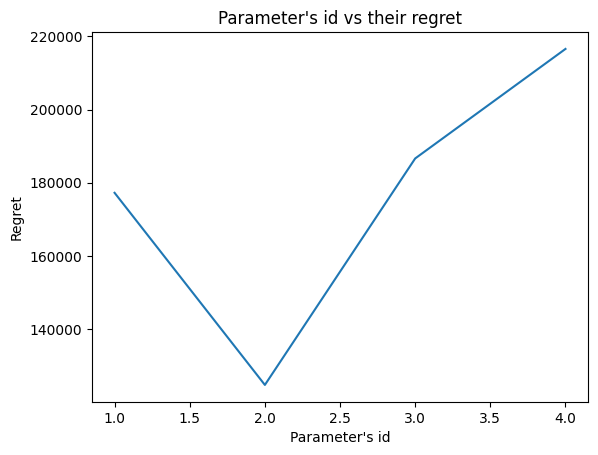

In [14]:
y = list(dict_2_1.values())
x = [1, 2, 3, 4]
plt.plot(x, y)
plt.title("Parameter's id vs their regret")
plt.xlabel("Parameter's id")
plt.ylabel("Regret")
plt.show()